In [6]:
from einops import rearrange, repeat
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from tqdm import trange

from drumblender.utils.modal_analysis import CQTModalAnalysis
from drumblender.synths import ModalSynthFreqs,NoiseGenerator

# Auxiliary functions extracted from nbdev
from aux_functions import load_audio_torch, ddsp_msfft_loss

## Tom Drum

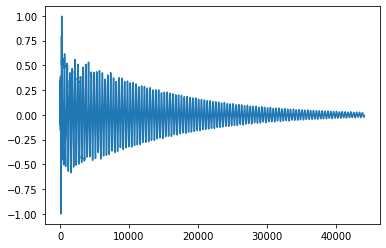

In [2]:
target, sr = load_audio_torch("audio/db_tom_1.wav")

# Pad to 1 second
if target.shape[1] < sr:
    target = torch.nn.functional.pad(target, (0, sr - target.shape[1]))

plt.plot(target[0].numpy())
ipd.Audio(target[0].numpy(), rate=sr)

### Constant-Q Spectrogram

In [3]:
hop_length = 64
fmin = 20.0
n_bins = 96
bins_per_octave = 12
cqt_analysis = CQTModalAnalysis(
    sample_rate=sr,
    hop_length=hop_length,
    fmin=fmin,
    n_bins=n_bins,
    bins_per_octave=bins_per_octave,
    num_modes=30,
    pad_mode="reflect",
)

CQT kernels created, time used = 0.1345 seconds


## Modal Resynthesis

torch.Size([1, 30, 690]) torch.Size([1, 30, 690]) torch.Size([1, 30, 690])


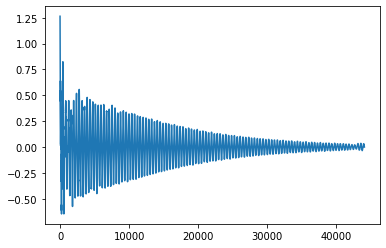

In [4]:
freqs, amps, phases = cqt_analysis(target)
print(freqs.shape, amps.shape, phases.shape)

freq_env = 2 * np.pi * freqs / sr
phase_start = phases[:,:,0]

modal_synth = ModalSynthFreqs(window_size=hop_length*2)


modal_out = modal_synth((amps,freq_env,phase_start))
plt.plot(modal_out[0].numpy())
ipd.Audio(modal_out[0].numpy(), rate=sr)

## Fine tuning modal amplitudes and phases
Using DDSP MS Spectrogram Loss

In [5]:
class DDSPFineTuneDrum:

    def __init__(self, opt_synth, iters=2000, lr=1e-3, scales = [1024,512,128], overlap=0.5):
        self.synth = opt_synth
        self.iters = iters
        self.lr = lr
        self.opt = torch.optim.Adam(self.synth.parameters(), lr=self.lr)
        self.loss_log = []
        self.scales = scales
        self.overlap = overlap
    
    def __call__(self, x):
        
        t = trange(self.iters, desc='Error', leave=True)
        for i in t:
            
            # Compute the sinusoid with updated paraetmers
            x_hat = self.synth()
            #print(x_hat.size())
            err = ddsp_msfft_loss(x,x_hat,self.scales,self.overlap)

            self.loss_log.append(err.detach().numpy())
            
            # Update tqdm description
            t.set_description(f"Error: {err.detach().numpy()}")

            # Optimize
            self.opt.zero_grad()
            err.backward()
            self.opt.step()

In [7]:
class ModalNoiseTuner(nn.Module):
    def __init__(self,
                 modal_synth : ModalSynthFreqs,
                 noise_synth : NoiseGenerator,
                 freqs : torch.Tensor,
                 amps : torch.Tensor,
                 phases : torch.Tensor,
                 n_bands : int,
                 sr : int):
        super().__init__()
        self.modal_synth = modal_synth
        self.noise_synth = noise_synth
        #self.freqs = self.register_buffer('modal freqs',freqs)
        self.freqs = freqs
        self.amps = nn.Parameter(amps,requires_grad=True)
        self.phases = nn.Parameter(phases,requires_grad=True)
        noise_bands = torch.rand(amps.shape[0],amps.shape[2],n_bands)
        self.noise_bands = nn.Parameter(noise_bands,requires_grad=True)
        self.sr = sr
    
    def forward(self):
        freq_env = 2 * np.pi * self.freqs / self.sr
        tuner_out = self.modal_synth((self.amps,freq_env,self.phases)) + \
            self.noise_synth(self.noise_bands)
        return tuner_out
        

In [12]:
noise_synth = NoiseGenerator(window_size=hop_length*2)
n_bands = 60
tuner = ModalNoiseTuner(modal_synth,noise_synth,freqs,amps,phase_start,n_bands,sr)

x = tuner()
#optimize = DDSPFineTuneDrum(tuner, iters=50, lr=1e-3)
#optimize(target)

RuntimeError: Given output_size=(1, 8128), kernel_size=(1, 128), dilation=(1, 1), padding=(0, 64), stride=(64, 64), expected size of input's dimension 2 to match the calculated number of sliding blocks 1 * 128 = 128, but got input.size(2)=690.

In [ ]:
x = tuner()

plt.plot(target[0].detach().numpy(), label="target")
plt.plot(x[0].detach().numpy(), label="match")
plt.legend()
plt.show()

ipd.display(ipd.Audio(x[0].detach().numpy(), rate=sr))
ipd.display(ipd.Audio(kick[0].detach().numpy(), rate=sr))